In [1]:
from hydra.utils import instantiate
from omegaconf import DictConfig
import torch
import torch.nn.functional as F

import pytorch_lightning as pl
from pydoc import locate
import re, os
import omegaconf
from awesome_ssl.models.model_utils import build_module
from awesome_ssl.models.eval_byol import BYOL_Eval
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def load_model(train_dir): 
    model_config_path = os.path.join(train_dir, ".hydra/config.yaml")
    run_conf = omegaconf.OmegaConf.load(model_config_path)
    print(run_conf, run_conf.model.target)
    if "transforms" in run_conf: 
        model = build_module(run_conf.model, transforms=run_conf.transforms)
    else: 
        model = build_module(run_conf.model)

    # load weight 
    model = model.load_from_checkpoint(os.path.join(train_dir, "checkpoints", "epoch_999.ckpt"))
    return model.eval()

def load_linear_model(path): 
    return BYOL_Eval.load_from_checkpoint(path)
    

In [4]:
## load image dataset 
from hydra.utils import instantiate 
from hydra import initialize, compose

# grab dataset
def grab_dataloader(): 
    with initialize("../configs"): 
        val_dataset = torch.utils.data.DataLoader(instantiate(compose("val_dataset/imagenette_val.yaml")).val_dataset, 
                                             batch_size=10)
    return val_dataset

In [3]:
def get_model_prediction(model, batch): 
    rep = model.model.get_representation(batch)
    return torch.argmax(model.classifier(rep), axis=1)

def get_all_model_outputs(model, dataloader): 
    model = model.cuda()
    predictions = []
    accuracies = []
    for batch, label in dataloader: 
        predicted = get_model_prediction(model, batch.cuda())
        predictions.append(predicted)
        accuracies.append(predicted == label.cuda())
    return torch.cat(predictions), torch.cat(accuracies)

In [4]:
datas = [
    ("/mnt/nfs/home/yunxingl/self-supervised-learning/outputs/2022-02-01/14-44-38/linear_checkpoint/epoch_999-epoch=9-val_loss=0.282436728477478.ckpt", "simclr_default_with_crop_2"), 
    ("/mnt/nfs/home/yunxingl/self-supervised-learning/outputs/2022-01-14/08-05-55/linear_checkpoint/epoch_999-epoch=5-val_loss=0.3018397092819214.ckpt", "simclr_default_with_crop"),
    ("/mnt/nfs/home/yunxingl/self-supervised-learning/outputs/2022-01-11/12-56-49/linear_checkpoint/epoch_999-epoch=8-val_loss=1.0149250030517578.ckpt", "simclr_big_batch"), 
    ("/mnt/nfs/home/yunxingl/self-supervised-learning/outputs/2022-02-01/14-08-35/linear_checkpoint/epoch_999-epoch=9-val_loss=1.109576940536499.ckpt", "simclr_no_crop_2"),
    ("/mnt/nfs/home/yunxingl/self-supervised-learning/outputs/2021-11-15/10-24-32/linear_checkpoint/epoch_459-epoch=8-val_loss=2.1192965507507324.ckpt", "byol_weak_colorjitter_nocrop, 459"), 
    ("/mnt/nfs/home/yunxingl/self-supervised-learning/outputs/2022-02-08/14-23-58/linear_checkpoint/epoch_449-epoch=5-val_loss=1.9708458185195923.ckpt", "byol_no_crop_2, 449"), 
    ("/mnt/nfs/home/yunxingl/self-supervised-learning/outputs/2021-11-15/10-24-32/linear_checkpoint/epoch_999-epoch=5-val_loss=2.243643045425415.ckpt", "byol_weak_colorjitter_nocrop, 999"), 
    ("/mnt/nfs/home/yunxingl/self-supervised-learning/outputs/2022-02-08/14-23-58/linear_checkpoint/epoch_999-epoch=7-val_loss=2.6529009342193604.ckpt", "byol_no_crop_2, 999"),
    ("/mnt/nfs/home/yunxingl/self-supervised-learning/outputs/2021-11-15/10-20-24/linear_checkpoint/epoch_959-epoch=9-val_loss=0.36358094215393066.ckpt", "byol_crop_and_strong_colorjitter")
]

def plot_corr(corr_matrix, title): 
    ticks = [x[1] for x in datas]
    return sns.heatmap(corr_matrix, 
            xticklabels=ticks,
            yticklabels=ticks, 
            annot=True)

In [5]:

# all_data = []
# accuracies = []
# dataloader = grab_dataloader()
# for path, name in datas: 
#     model = load_linear_model(path)
#     preds, accs = get_all_model_outputs(model, dataloader)
#     all_data.append(preds)
#     accuracies.append(accs)
    
# torch.save(all_data, "all_model_labels.pkl")
# torch.save(accuracies, "all_model_equal_label.pkl")

all_data = torch.load("all_model_labels.pkl")
accuracies = torch.load("all_model_equal_label.pkl")

torch.Size([9, 3925, 1]) torch.Size([1, 3925, 9])


<AxesSubplot:>

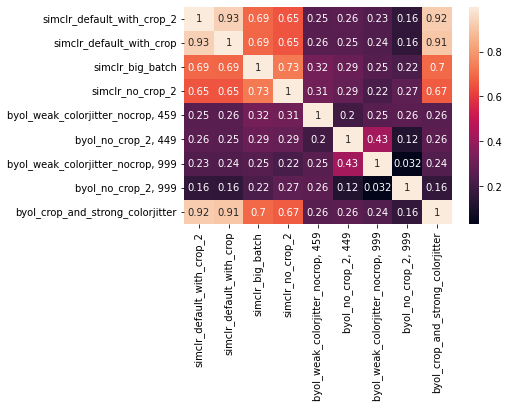

In [34]:
res = torch.cat([t.unsqueeze(1) for t in all_data], axis=1)
t1 = res.t().unsqueeze(2)
t2 = res.unsqueeze(0)
print(t1.shape, t2.shape)
corr_eq = (t1 == t2).float().mean(dim=1)
plot_corr(corr_eq.cpu(), "Percentage of Outputs Are Equal")

simclr_default_with_crop_2 accuracy: 0.9149044156074524
simclr_default_with_crop accuracy: 0.9001273512840271
simclr_big_batch accuracy: 0.6792356371879578
simclr_no_crop_2 accuracy: 0.6499362587928772
byol_weak_colorjitter_nocrop, 459 accuracy: 0.2524840533733368
byol_no_crop_2, 449 accuracy: 0.25375795364379883
byol_weak_colorjitter_nocrop, 999 accuracy: 0.2346496731042862
byol_no_crop_2, 999 accuracy: 0.15898087620735168
byol_crop_and_strong_colorjitter accuracy: 0.8894267082214355
torch.Size([9, 3925, 1]) torch.Size([1, 3925, 9])


<AxesSubplot:>

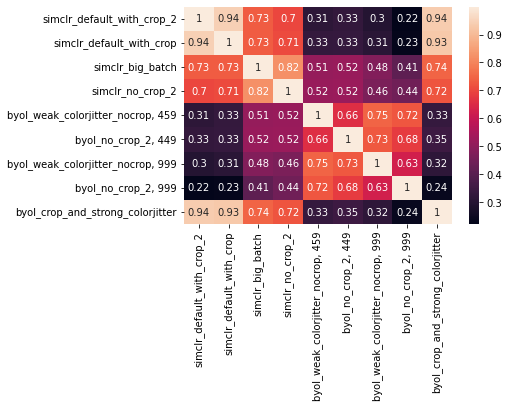

In [35]:
res = torch.cat([t.unsqueeze(1) for t in accuracies], axis=1)
accs = res.float().mean(axis=0).tolist()
for idx, val in enumerate(accs): 
    print(f"{datas[idx][1]} accuracy: {val}")
t1 = res.t().unsqueeze(2)
t2 = res.unsqueeze(0)
print(t1.shape, t2.shape)
corr = (t1 == t2).float().mean(dim=1)
plot_corr(corr.cpu(), "Percentage of Outputs Are Equal")

torch.bool


<AxesSubplot:>

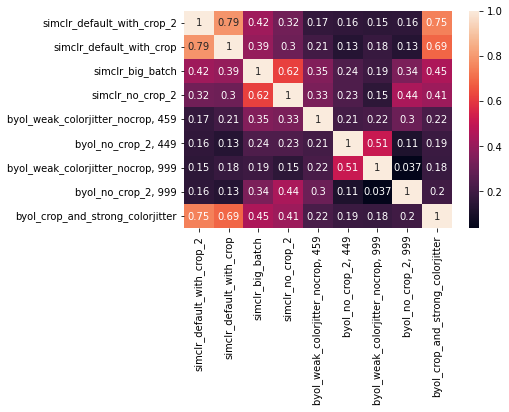

In [9]:
res_pred = torch.cat([t.unsqueeze(1) for t in all_data], axis=1).float()
res_acc = torch.cat([t.unsqueeze(1) for t in accuracies], axis=1)
t1_pred = res_pred.t().unsqueeze(2)
t2_pred = res_pred.unsqueeze(0)
t1_acc = res_acc.t().unsqueeze(2)
t2_acc = res_acc.unsqueeze(0)
print(t1_acc.dtype)
both_incorrect = ~(t1_acc | t2_acc)
both_incorrect = both_incorrect.float()
corr = torch.sum(((t1_pred == t2_pred) * both_incorrect), dim=1) / torch.sum(both_incorrect, dim=1)
plot_corr(corr.cpu(), "Percentage of Outputs Are Equal")